Keras implementaion of 'Deep convolutional neural network for the automated detection and diagnosis of seizure using EEG signals', U. Rajendra Acharya, Shu Lih Oh, Yuki Hagiwara, Jen Hong Tan, Hojjat Adeli.  https://www.ncbi.nlm.nih.gov/pubmed/28974302

In [1]:
import glob
import numpy as np

input files:

* 'a (1)' to 'a (200)' (Normal )
* 'b (1)' to 'b (200)' (Pre-ictal)
* 'c (1)' to 'c (100)' (Seizure)

sample file listing:

a (100).txt,  a (177).txt,  a (71).txt,   b (148).TXT,  b (42).txt,	 c (28).txt

a (101).txt,  a (178).txt,  a (72).txt,   b (149).TXT,  b (43).txt,	 c (29).txt

a (102).txt,  a (179).txt,  a (73).txt,  b (14).txt,   b (44).txt,	 c (2).txt

In [2]:
file_sets = ['a', 'b', 'c']
label_sets = [1, 2, 3] # 1->Normal, 2->Preictal,  3-> Seizure

In [3]:
import os

data=[]
labels = []
for file_set, label in zip(file_sets, label_sets):

    for file in glob.glob("input/all/" + file_set + "*.*"):
        with open(file) as f:
            int_list = [int(x) for x in f]
            data.append(int_list)
            labels.append(label)
            
data = np.asarray(data).astype('float32')
labels = np.asarray(labels)
print('shape of data:', data.shape)
print('shape of labels:', labels.shape)

shape of data: (500, 4097)
shape of labels: (500,)


In [4]:
np.unique(labels, return_counts=True)

(array([1, 2, 3]), array([200, 200, 100]))

In [5]:
# reshape the data
data = data[:,:,np.newaxis]
print(data.shape)

(500, 4097, 1)


In [6]:
# randomize the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

### Train test split

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, labels, 
                                                stratify = labels, random_state = 123)

print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)

x_train shape: (375, 4097, 1)
x_val shape: (125, 4097, 1)


### Normalize data

In [8]:
mean = x_train.mean()
x_train -= mean
std = x_train.std()
x_train /= std

x_val -= mean
x_val /= std

### one-hot encode targets

In [9]:
def one_hot(labels, n_class = 3):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

In [10]:
y_train = one_hot(y_train)
y_val = one_hot(y_val)

In [11]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [12]:
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=6, input_shape=x_train.shape[1:3],
                activation='relu'))
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=4, kernel_size=5, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=10, kernel_size=4, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=10, kernel_size=4, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=15, kernel_size=4, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling1D(2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001),
            metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4092, 4)           28        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2046, 4)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2042, 4)           84        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2042, 4)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1021, 4)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1018, 10)          170       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1018, 10)          0         
__________

In [13]:
history = model.fit(x_train,y_train, batch_size=3, epochs=150,validation_data=(x_val,y_val) )

Train on 375 samples, validate on 125 samples
Epoch 1/150
375/375 [==============================] - 2s - loss: 1.0420 - acc: 0.3253 - val_loss: 0.9805 - val_acc: 0.4240
Epoch 2/150
375/375 [==============================] - 0s - loss: 0.9197 - acc: 0.5147 - val_loss: 0.8739 - val_acc: 0.5840
Epoch 3/150
375/375 [==============================] - 0s - loss: 0.7782 - acc: 0.5787 - val_loss: 0.7442 - val_acc: 0.5600
Epoch 4/150
375/375 [==============================] - 0s - loss: 0.6729 - acc: 0.5760 - val_loss: 0.6821 - val_acc: 0.5600
Epoch 5/150
375/375 [==============================] - 0s - loss: 0.6167 - acc: 0.6800 - val_loss: 0.6300 - val_acc: 0.7680
Epoch 6/150
375/375 [==============================] - 0s - loss: 0.5551 - acc: 0.8027 - val_loss: 0.5826 - val_acc: 0.8560
Epoch 7/150
375/375 [==============================] - 0s - loss: 0.4892 - acc: 0.8853 - val_loss: 0.5107 - val_acc: 0.8640
Epoch 8/150
375/375 [==============================] - 0s - loss: 0.4249 - acc: 0.8880

375/375 [==============================] - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1950 - val_acc: 0.9520
Epoch 67/150
375/375 [==============================] - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.2066 - val_acc: 0.9440
Epoch 68/150
375/375 [==============================] - 0s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.2053 - val_acc: 0.9360
Epoch 69/150
375/375 [==============================] - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.2051 - val_acc: 0.9440
Epoch 70/150
375/375 [==============================] - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.2262 - val_acc: 0.9360
Epoch 71/150
375/375 [==============================] - 0s - loss: 8.8969e-04 - acc: 1.0000 - val_loss: 0.2078 - val_acc: 0.9520
Epoch 72/150
375/375 [==============================] - 0s - loss: 8.3053e-04 - acc: 1.0000 - val_loss: 0.2151 - val_acc: 0.9520
Epoch 73/150
375/375 [==============================] - 0s - loss: 7.7774e-04 - acc: 1.0000 - val_loss: 0.2110 - val_acc: 0.9440
E

375/375 [==============================] - 0s - loss: 9.0649e-06 - acc: 1.0000 - val_loss: 0.2975 - val_acc: 0.9360
Epoch 130/150
375/375 [==============================] - 0s - loss: 7.8864e-06 - acc: 1.0000 - val_loss: 0.3172 - val_acc: 0.9360
Epoch 131/150
375/375 [==============================] - 0s - loss: 8.0168e-06 - acc: 1.0000 - val_loss: 0.3058 - val_acc: 0.9360
Epoch 132/150
375/375 [==============================] - 0s - loss: 7.3078e-06 - acc: 1.0000 - val_loss: 0.3299 - val_acc: 0.9360
Epoch 133/150
375/375 [==============================] - 0s - loss: 6.4133e-06 - acc: 1.0000 - val_loss: 0.3339 - val_acc: 0.9360
Epoch 134/150
375/375 [==============================] - 0s - loss: 5.9551e-06 - acc: 1.0000 - val_loss: 0.3441 - val_acc: 0.9280
Epoch 135/150
375/375 [==============================] - 0s - loss: 5.7542e-06 - acc: 1.0000 - val_loss: 0.3149 - val_acc: 0.9360
Epoch 136/150
375/375 [==============================] - 0s - loss: 5.2287e-06 - acc: 1.0000 - val_loss:

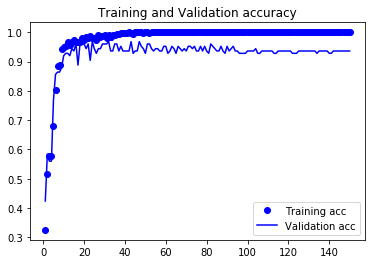

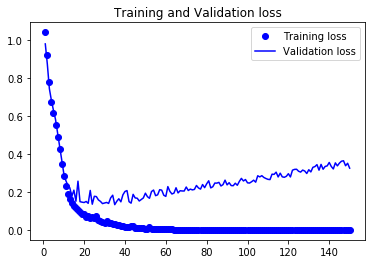

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [15]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp

n_classes = y_val.shape[1]
y_score = model.predict(x_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

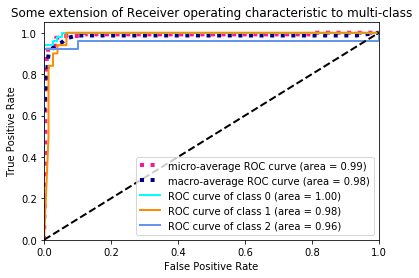

In [16]:

lw = 2
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()